# Check BCI ErrPs
Use this clean notebook to check the Error-related Potentials (ErrPs) in the BCI data!

Nile Wilson 2019.01.29-30

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from matplotlib import pyplot as plt
from scipy.fftpack import fft, ifft
from scipy import signal
from mne.filter import filter_data

import scipy.signal as scisig
import numpy as np
import pandas as pd
import datetime
import pickle
import glob
import csv
import mne

# WARNING
Make sure to change the filepath search locations when making this a function! It currently looks for stuff in the same folder or ../data/nile/, but should be savedata (check capitalization) in the end!

## Function Definitions

Functions for working with the BCI data

In [2]:
def LoadEEGData(filename, EEGdevice):
    """ This function converts a single .easy file (from NIC2) to an easy-to-use dataframe.
    Uses both the .easy file and .info file (containing metadata)
    
    ---- Input ----
    filename: string containing the .easy filepath
    
    ---- Output ----
    df: dataframe containing all the EEG, accelerometer, and event marker data
    fs: sampling rate for the EEG data (Hz)
    fs_accel: sampling rate for the accelerometer data (Hz)
    
    """
    if EEGdevice == 7:
        x = 1
    elif EEGdevice == 8:
        # Read in the .easy file
        df = pd.read_csv(filename, delimiter='\t', header=None)

        # Get metadata from the .info file
        fname = filename[:-5] + '.info'
        with open(fname) as f:
            content = f.readlines()
        content = [x.strip() for x in content]

        # Get the channel names
        channel_info = [x for x in content if 'Channel ' in x]
        channel_names = []
        for ch in range(len(channel_info)):
            channel_names.append(channel_info[ch].split(': ')[1])

        channel_names.append('X')
        channel_names.append('Y')
        channel_names.append('Z')
        channel_names.append('STI 014')
        channel_names.append('DateTime')

        # Get sampling rates
        sampling_rates = [x for x in content if 'sampling rate: ' in x]
        fs_all = []
        for freq in range(len(sampling_rates)):
            tmp = sampling_rates[freq].split(': ')[1].split(' ')[0]
            if tmp in ['N/A']:
                print('Skipping N/A')
            else:
                fs_all.append(float(sampling_rates[freq].split(': ')[1].split(' ')[0]))

        # Store sampling rates
        fs = fs_all[0]
        fs_accel = fs_all[1]

        # Assign the column names
        df.columns = channel_names
    
    # Return dataframe and sampling rates
    return df, fs, fs_accel

In [3]:
def LoadBehavioralDataBCI(filename_behavioral):
    """
    This function loads behavioral data for the motor screening task and formats it to use in this script
    """
    behavioralData = pd.read_csv(filename_behavioral, ',')
    
    return behavioralData

In [4]:
def SyncTriggerPulsesBCI(EEGdata, EEGdevice, fs, behavioralData):
    """
    This function returns the indices for events of interest
    """
    
    if EEGdevice == 7:
        print('Put code here')
    elif EEGdevice == 8:
        # Store where the values in trigger are equal to 8 (the audio trigger input channel number)
        index_trigger = np.where(EEGdata['STI 014']!=0)
        index_trigger = index_trigger[0]

        # Number of trials is greater than number of total pulses sent
        # 999 when the task ends
        move_left_starts = np.where(EEGdata['STI 014'] == 1)[0]
        move_right_starts = np.where(EEGdata['STI 014'] == 2)[0]
        rest_starts = np.where(EEGdata['STI 014'] == 3)[0]
        rest_ends = np.where(EEGdata['STI 014'] == 4)[0]
        
        # If the number of rest_starts and rest_ends don't match, drop the extra one
        # there should, by default, only be 12 starts and 12 ends

        if len(rest_ends) > len(rest_starts):
            if rest_ends[0] < rest_starts[0]:
                rest_ends = rest_ends[1:]
        elif len(rest_ends) < len(rest_starts):
            if rest_ends[0] > rest_starts[0]:
                rest_starts = rest_starts[1:]
        
        move_starts = np.sort(np.concatenate((move_left_starts,move_right_starts),0))
        total_movements = len(move_starts)

        # exclude movements that occur without defined baseline (if you need to get rid of first rest)
        hasBaseline = list()
        for movement in range(0,len(move_starts)):
            hasBaseline.append(True in (rest_starts < move_starts[movement]))

        np.where(hasBaseline)
        move_starts = move_starts[np.where(hasBaseline)]

        # exclude the move lefts and move rights that were thrown out in move_starts
        for movement in range(0,total_movements):
            if hasBaseline[movement] is False:
                # for the left movements
                idx_left = np.where(move_left_starts == move_starts[movement])
                idx_left = np.asarray(idx_left)
                idx_right = np.where(move_right_starts == move_starts[movement])
                idx_right = np.asarray(idx_right)

                if idx_left.size > 0:
                    move_left_starts = np.delete(move_left_starts, idx_left)
                if idx_right.size > 0:
                    move_right_starts = np.delete(move_right_starts, idx_right)
                
        num_of_trials = len(rest_starts)
        num_of_movements = len(move_left_starts) + len(move_right_starts)
    
    return num_of_trials, num_of_movements, move_starts, hasBaseline, rest_starts, rest_ends

In [5]:
def EpochBCIData(EEGdata, move_starts, rest_starts, rest_ends):
    """
    This function epochs the data
    """
    
    if EEGdevice == 7:
        channels = EEGdata.columns[1:8]
    elif EEGdevice == 8:
        channels = EEGdata.columns[0:8]

    epochs = []
    epochs_norm = []

    for movement in range(0,len(move_starts)):
        # Data for this movement
        t_start = move_starts[movement] - np.round(1.00*fs)
        t_end = move_starts[movement] - np.round(0.250*fs)

        # Baseline
        restOfInt = np.max(np.where(rest_starts < move_starts[movement]))
        tb_start = rest_starts[restOfInt]
        tb_end = rest_ends[restOfInt]

        baseline = EEGdata.loc[tb_start:tb_end][channels]

        # Store epoch
        tmp = (EEGdata.loc[t_start:t_end][channels] - np.mean(baseline))/np.std(baseline)
        epochs_norm.append(tmp)
        epochs.append(EEGdata.loc[t_start:t_end][channels])

    return epochs, epochs_norm

In [6]:
def OrganizeTrials(behavioralData, hasBaseline):
    """
    Organizes trials
    """
    
    # When target was to the left
    trialL = np.where(behavioralData['target_x'] < behavioralData['player_x'])
    
    # When target was to the right
    trialR = np.where(behavioralData['target_x'] > behavioralData['player_x'])
    
    # Create a single list that includes which trial is which (L = 0, R = 1)
    trial_type = np.zeros([1,len(behavioralData['score'])])
    trial_type[0][trialL] = 0
    trial_type[0][trialR] = 1

    trial_type = np.round(trial_type[0])
    
    # Remove trials if no baseline
    for movement in range(0,len(hasBaseline)):
        if hasBaseline[movement] is False:
            trial_type = np.delete(trial_type, movement)
            
    return trial_type

In [7]:
def ExtractFeaturesBCI(epochs, num_of_movements, channelsToUse, ds_factor):
    """
    Extract signal features of interest
    """
    
    # Get the summed delta power for each trial
    alpha_power = dict.fromkeys(channelsToUse)
    beta_power = dict.fromkeys(channelsToUse)
    ds_f = ds_factor # downsampling factor

    for chanOfInt in channelsToUse:
        tmp_alpha = list()
        tmp_beta = list()

        for movement in range(0, num_of_movements):
            f, Pxx_den = signal.welch(signal.decimate(epochs[movement][chanOfInt],ds_f), fs/ds_f, scaling='spectrum')
            alpha_idx = np.where(np.logical_and(np.round(f) > 8, np.round(f) <= 12))
            tmp_alpha.append(np.sum(Pxx_den[alpha_idx]))

            beta_idx = np.where(np.logical_and(np.round(f) > 13, np.round(f) <= 30))
            tmp_beta.append(np.sum(Pxx_den[beta_idx]))

        alpha_power[chanOfInt] = tmp_alpha
        beta_power[chanOfInt] = tmp_beta
    
    return alpha_power, beta_power

In [8]:
def TrainDecoder(X, y):
    """
    Trains the decoder on ALL the data (does not split into test and train because this is all train)
    """
    # preprocess dataset, split into training and test part
    args = np.arange(len(X))
    np.random.shuffle(args)
    X = [X[i] for i in args]
    y = [y[i] for i in args]
    X = StandardScaler().fit_transform(X)
    

    # Determine model parameters
    activations = ['relu','tanh']
    alphas = np.logspace(-6, 3, 10)
    solvers = ['lbfgs','sgd']
    hyper_params = {"activation":activations, "alpha":alphas, "solver":solvers}
    grid = GridSearchCV(MLPClassifier(learning_rate='constant', random_state=1), param_grid=hyper_params, cv=KFold(n_splits=5), verbose=True)
    grid.fit(X, y)

    # Fit the model
    clf = grid.best_estimator_
    clf.fit(X,y)
    
    """
    # Split into train and test for evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    grid.fit(X_train, y_train)

    # Fit the model
    clf = grid.best_estimator_
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    print(grid.best_estimator_)
    print('-----------')
    print('score: ' + str(score))
    print(confusion_matrix(y_test, clf.predict(X_test)))
    print('-----------')
    """
    
    return clf, X, y

Functions for working with error (ErrPs)

In [9]:
def EpochErrorData(EEGdata, fs, EEGdevice, t_trial_start):
    """
    This function epochs the data
    """
    if EEGdevice == 7:
        channels = EEGdata.columns[1:8]
    elif EEGdevice == 8:
        channels = EEGdata.columns[0:8]

    epochs = []

    for trial in range(0,len(t_trial_start)):
        t_start = t_trial_start[trial] - np.round(0  * fs)
        t_end = t_trial_start[trial] + np.round(0.600 * fs)

        # Baseline
        tb_start = t_trial_start[trial] - np.round(0.700 * fs)
        tb_end = t_trial_start[trial] - np.round(0.100 * fs)
        baseline = EEGdata.loc[tb_start:tb_end][channels]

        # Store epoch
        tmp = (EEGdata.loc[t_start:t_end][channels] - np.mean(baseline))/np.std(baseline)
        epochs.append(tmp)
    
    return epochs

In [10]:
def ExtractErrorFeatures(epochs, num_of_trials, error_template, correct_template, featureType):
    """
    Extract signal features of interest
    featureType:    'template' or 'frequency'. 'template' returns features based on the template projection values
                    for individual epochs with the error and correct templates. 'frequency' returns features that
                    are just delta and theta power for each channel for the epochs
    """
    
    if featureType in ['template','Template','TEMPLATE','t','T','projection','Projection','PROJECTION','p','P']:
        # template_projection[chanOfInt] will have two columns
        # col 1: how well the trial signal matches with the error signal template
        # col 2: how well the trial signal matches with the correct signal template
        projections_all = dict()
        channelsToUse = error_template.keys()

        for chanOfInt in channelsToUse:
            projections = np.zeros([2, num_of_trials])
            for trial in range(0, num_of_trials):
                # Individual epoch (normalized)
                tmp = epochs_norm[trial][chanOfInt]
                a = tmp

                # Template waveform for error (normalized)
                tmp0 = error_template[chanOfInt]
                tmp_norm = (tmp0 - np.mean(tmp0))/np.std(tmp0)
                b = tmp_norm

                # Template waveform for correct (normalized)
                tmp = correct_template[chanOfInt]
                tmp_norm = (tmp - np.mean(tmp0))/np.std(tmp0)
                c = tmp_norm

                # Store sum of convolutions

                projections[0][trial] = np.sum(np.convolve(a,b,'same'))
                projections[1][trial] = np.sum(np.convolve(a,c,'same'))

            projections_all[chanOfInt] = projections
        
        # Organize the features
        channels = list(projections_all.keys())
        num_of_features = np.shape(projections_all['Cz'])[0] * len(channels)
        channels_full = list(projections_all.keys()) * 2
        num_of_trials = np.shape(projections_all['Cz'])[1]

        features = np.zeros([num_of_features, num_of_trials])

        for trial in range(0, num_of_trials):
            # Error trials are 0 to num_of_features//2, and correct trials are num_of_features//2 to num_of_features
            for feature in range(0, num_of_features):
                features[feature, trial] = projections_all[channels_full[feature]][0][trial]
            
    elif featureType in ['frequency','Frequency','FREQUENCY','f','F']:
        channelsToUse = error_template.keys()
        delta_power = dict.fromkeys(channelsToUse)
        theta_power = dict.fromkeys(channelsToUse)
        ds_f = 1 # downsampling factor

        for chanOfInt in channelsToUse:
            tmp_delta = list()
            tmp_theta = list()

            for trial in range(0, num_of_trials):
                f, Pxx_den = signal.welch(signal.decimate(epochs_norm[trial][chanOfInt],ds_f), fs/ds_f, scaling='spectrum')
                delta_idx = np.where(np.round(f) <= 4)
                tmp_delta.append(np.sum(Pxx_den[delta_idx]))

                theta_idx = np.where(np.logical_and(np.round(f) > 4, np.round(f) <= 7))
                tmp_theta.append(np.sum(Pxx_den[theta_idx]))

            delta_power[chanOfInt] = tmp_delta
            theta_power[chanOfInt] = tmp_theta
            
        # Organize the features
        num_of_examples = len(delta_power['Cz'])
        num_of_features = len(delta_power.keys()) + len(theta_power.keys()) 
        features = np.zeros([num_of_features, num_of_examples])

        # Get all channels in one list to loop through
        feature_channels = np.concatenate([np.asarray(list(delta_power.keys())),np.asarray(list(theta_power.keys()))])

        for i in range(0, num_of_examples):
            for j in range(0, num_of_features//2):
                features[j, i] = delta_power[feature_channels[j]][i]
            for j in range(num_of_features//2, num_of_features):
                features[j, i] = theta_power[feature_channels[j]][i]

    
    return features

In [11]:
def ConfidenceScoreExamples(X, y, EEGdata, EEGdevice, fs, num_of_movements, move_starts, trial_type):
    """
    This is the function that does the confidence scoring based on error detection and attention
    """
    # Load the error detection model and see what featureType it used (frequency or template projections)
    models = glob.glob('../data/nile/' + subjID + '_Error_classifier_*')
    model_file = models[-1] # load the most recent model
    clf_error = pickle.load(open(model_file, 'rb'))
    print(model_file)
    print(clf_error)

    models_data_list = glob.glob('../data/nile/' + subjID + '_data_for_Error_classifier_*')
    models_data = models_data_list[-1] # load the most recent model
    loaded_data = np.load(models_data)
    featureType = loaded_data['featureType']
    
    # Load templates if applicable
    error_template = loaded_data['error_template'].tolist()
    correct_template = loaded_data['correct_template'].tolist()

    # Create new epochs for error detection
    epochs = EpochErrorData(EEGdata, fs, EEGdevice, move_starts)
    features = ExtractErrorFeatures(epochs, num_of_movements, error_template, correct_template, featureType)
    features = features.T
    
    # Scale the features
    features = StandardScaler().fit_transform(features)
    
    # Detect error
    preds_error = clf_error.predict(features) # is there an ErrP or not? 1 = yes ErrP, 0 = no ErrP
    preds_error_proba = clf_error.predict_proba(features) # what is the prob of there being an ErrP?
    
    # Confidence in the prediction of error
    prob_error = (preds_error_proba[:,1] * preds_error)

    # Confidence in the prediction of no error
    prob_no_error = preds_error_proba[:,0] * (1-preds_error)

    # Confidence the epoch is correct
    CS = (prob_no_error - prob_error + 1)/2
    
    """
    Also return true label stuff
    """
    # Also return true label scores
    # Load the error detection model and see what featureType it used (frequency or template projections)
    models = glob.glob(subjID + '_MI_classifier_*')
    model_file = models[-1] # load the most recent model
    clf_MI = pickle.load(open(model_file, 'rb'))

    preds_MI = clf_MI.predict(X)
    
    # trial_type 0 is L, trial_type 1 is R, and TL 1 is high confidence (correct), and TL 0 is low confidence (error)
    TL = list()
    for trial in range(0, len(trial_type)):
        if trial_type[trial] == 0:
            if preds_MI[trial] == 0:
                TL.append(1)
            else:
                TL.append(0)
        elif trial_type[trial] == 1:
            if preds_MI[trial] == 1:
                TL.append(1)
            else:
                TL.append(0)

    return CS, TL, preds_MI, preds_error, preds_error_proba, epochs, features, clf_error

In [12]:
def RetrainDecoder(clf, CS, threshold, X_old, y_old, X_new, y_new, adaptationType):
    """
    Retrains the decoder on ALL the previous data plus what you decided to add in with high confidence scores
    
    clf: your preloaded model (most recent version)
    CS: confidence scores (if true labels, use TL instead of CS)
    X_old: your preloaded model data (X)
    y_old: your preloaded model data (y)
    X_new: your new motor features
    y_new: your new labels
    """
    # Concatenate old X and y with new X and y that have a high enough confidence score
    aboveThreshold = np.where(CS>threshold)
    
    X = np.concatenate((X_old, X_new[aboveThreshold]), axis=0)
    y = np.concatenate((y_old, np.asarray(y_new)[aboveThreshold]), axis=0)
    
    # preprocess dataset, split into training and test part
    args = np.arange(len(X))
    np.random.shuffle(args)
    X = [X[i] for i in args]
    y = [y[i] for i in args]
    X_not_scaled = X
    X = StandardScaler().fit_transform(X)

    # Fit the model
    clf.fit(X,y)
    
    """
    # Split into train and test for evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    grid.fit(X_train, y_train)

    # Fit the model
    clf = grid.best_estimator_
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    print(grid.best_estimator_)
    print('-----------')
    print('score: ' + str(score))
    print(confusion_matrix(y_test, clf.predict(X_test)))
    print('-----------')
    """
    
    return clf, X, X_not_scaled, y

In [13]:
def SaveDecoderAndData(clf, X, X_not_scaled, y, subjID):
    """
    Save the decoder and the data it was trained/tested on
    """
    time_to_save = datetime.datetime.now().isoformat()
    time_to_save = time_to_save.replace('T','-')
    time_to_save = time_to_save.replace(':','-')
    
    model = clf
    model_file = subjID + '_MI_classifier_' + time_to_save[:19] + '.sav'
    pickle.dump(model, open(model_file, 'wb'))
    
    filepath_export_data = subjID + '_data_for_MI_classifier_' + time_to_save[:19] + '.npz'
    np.savez_compressed(filepath_export_data, X=X, X_not_scaled=X_not_scaled, y=y)

## Variables to Set

In [14]:
# Load in the BCI data
subjID = 'nile'
EEGdevice = 8 # 7 for DSI-7, 8 for Enobio
filename_eeg = '../data/nile/20190130122905_nile_BCI.easy'
filename_behavioral = '../data/nile/BCI_nile_R1.csv'

## Code to Run

Load in the BCI data

In [15]:
# Load EEG data
EEGdata, fs, fs_accel = LoadEEGData(filename_eeg, EEGdevice)

# Load behavioral data
behavioralData = LoadBehavioralDataBCI(filename_behavioral)

# Sync up trigger pulses
num_of_trials, num_of_movements, move_starts, hasBaseline, rest_starts, rest_ends = SyncTriggerPulsesBCI(EEGdata, EEGdevice, fs, behavioralData)

# Clean the data
EEGdata_orig = EEGdata.copy()
lf = 1
hf = 40

if EEGdevice == 7:
    channels = EEGdata.columns[1:8]
elif EEGdevice == 8:
    channels = EEGdata.columns[0:8]

# Format our data into an mne-friendly format
ch_types = ['eeg']*len(channels)
info = mne.create_info(ch_names=list(channels), sfreq=fs, ch_types=ch_types)
rawData = EEGdata[channels].values
rawData = np.transpose(rawData)
raw = mne.io.array.RawArray(rawData, info)
raw.set_montage(mne.channels.read_montage(kind='standard_1020'))
raw.filter(l_freq=lf, h_freq=hf)

# Make a copy of the original data just in case
EEGdata[channels] = raw.get_data().T

# Epoch the data
epochs, epochs_norm = EpochBCIData(EEGdata, move_starts, rest_starts, rest_ends)

# Organize trial types
trial_type = OrganizeTrials(behavioralData, hasBaseline)

# Get signal features
alpha_power, beta_power = ExtractFeaturesBCI(epochs_norm, num_of_movements, ['C3','C4'], 1)
motor_features = [alpha_power['C3'], alpha_power['C4'], beta_power['C3'], beta_power['C4']]
motor_features = np.transpose(motor_features)

Skipping N/A
Creating RawArray with float64 data, n_channels=7, n_times=138604
    Range : 0 ... 138603 =      0.000 ...   277.206 secs
Ready.
Setting up band-pass filter from 1 - 40 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Filter length of 1651 samples (3.302 sec) selected


C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Load the MI classification model

In [16]:
# Load latest model and its associated data
models = glob.glob('../data/nile/' + subjID + '_MI_classifier_*')
model_file = models[-1] # load the most recent model
MI_model = pickle.load(open(model_file, 'rb'))

models_data_list = glob.glob('../data/nile/' + subjID + '_data_for_MI_classifier_*')
models_data = models_data_list[-1] # load the most recent model
MI_data = np.load(models_data)
X_loaded_MI = MI_data['X_not_scaled']
y_loaded_MI = MI_data['y']

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator SVC from version 0.20.2 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Find ErrPs in current BCI data (this function loads the most recent ErrP model for this subject, epochs for error, creates features, and classifies).

Make sure you've run Create_Error_Decoder first (right now it's just an .ipnyb)

In [17]:
# Choose which examples to keep through confidence scoring
X_new = motor_features
y_new = trial_type

CS, TL, preds_MI, preds_error, preds_error_proba, epochs, features, clf_error = ConfidenceScoreExamples(X_new, y_new, EEGdata, EEGdevice, fs, num_of_movements, move_starts, trial_type)

../data/nile\nile_Error_classifier_2019-01-30-14-38-17.sav
MLPClassifier(activation='tanh', alpha=0.1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


See Update_MI_Decoder.ipnyb if you need more tinkering code to copy over

In [18]:
preds_error

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0])

# Checking CS
Fixed it! Looks much better now

In [19]:
CS

array([2.58370814e-04, 3.60394644e-03, 1.09328275e-02, 1.51455076e-02,
       9.96619814e-01, 9.99999609e-01, 3.12212408e-02, 8.09533611e-01,
       2.90497339e-05, 9.99989654e-01, 1.00000000e+00, 9.99999969e-01,
       7.66388264e-01, 9.96754280e-01, 1.20835842e-02, 1.00000000e+00,
       7.77499315e-01, 1.00000000e+00, 9.99430544e-01, 9.99999972e-01,
       1.00000000e+00, 1.00000000e+00, 8.95241740e-01, 1.73288761e-08,
       1.00000000e+00, 9.99990377e-01, 1.00000000e+00, 9.99999967e-01,
       9.99996998e-01, 1.00000000e+00, 1.07894692e-03, 9.48236088e-01,
       9.78689734e-01, 1.84846271e-03, 1.29871795e-02, 4.70376612e-02,
       9.89220428e-03, 3.61523034e-03, 2.02502900e-03, 9.99898926e-01,
       8.06650013e-09, 9.92956100e-01, 2.70928865e-02, 1.93997454e-02,
       1.12696963e-07, 4.29740132e-05, 6.91473426e-03, 9.89606241e-01,
       9.99642885e-01, 1.00000000e+00, 1.00000000e+00, 6.48023368e-07,
       9.92382914e-01, 1.14026510e-02, 2.97823493e-03, 9.99999734e-01,
      

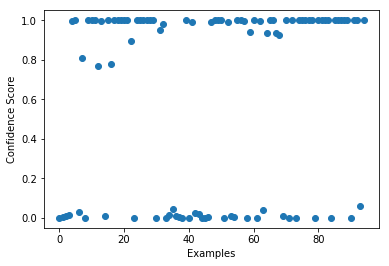

In [31]:
plt.figure()
plt.plot(CS,'o')
plt.xlabel('Examples')
plt.ylabel('Confidence Score')
plt.show()

In [67]:
np.round(CS)

array([0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
       1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 0., 1., 1., 0., 1.])

In [22]:
print(TL)

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


How well do our confidence scores match with the true labels? (Note, this is just for error classification, not MI)

In [60]:
# clf_error: our ErrP classifier
# TL: true labels for the performance monitoring epochs in this BCI data
# features: the features for the ErrP classifier for these performance monitoring epochs

print('Total number of examples: ' + str(len(features)))
print('Percent of correctly scored examples: ' + str(clf_error.score(features, TL)*100) + '%')
print('----------------')
print('Confusion Matrix for Error Classification (not MI)')
print(confusion_matrix(TL, clf_error.predict(features)))
print('----------------')

Total number of examples: 95
Percent of correctly scored examples: 55.78947368421052%
----------------
Confusion Matrix for Error Classification (not MI)
[[41 22]
 [20 12]]
----------------


# Retrain / update
Retrain and save MI classifier (with pre-scaled features), don't update error classifier

In [61]:
# Retrain
adaptationType = 'CS' # either 'CS' for confidence score, or 'TL' for true label
threshold = 0.7
clf, X, X_not_scaled, y = RetrainDecoder(MI_model, CS, threshold, X_loaded_MI, y_loaded_MI, motor_features, trial_type, adaptationType)

Check some values

In [62]:
len(X_loaded_MI)

990

In [63]:
len(X_new)

95

In [64]:
len(np.where(CS>0)[0])

95

In [65]:
len(X)

1051

## Save

In [ ]:
# Save decoder and data it was trained/tested on
SaveDecoderAndData(clf, X, X_not_scaled, y, subjID)